In [1]:
import sys
import re
import time
import datetime
import pandas as pd
import numpy as np
import func
# inline plot
import matplotlib.pyplot as plt
%matplotlib inline

/Users/albarron/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
df = pd.read_csv("data/merged_concat_final.csv",sep='\t',error_bad_lines=False)
del df['Unnamed: 0']
print df.shape

(21021, 33)


In [5]:
df.set_index('timestamp')
df['timestamp'] = pd.to_datetime(df['timestamp'],format="%Y-%m-%d %H:%M:%S")

In [6]:
only_delay = df[(df['is_delay']==1)]

In [7]:
print "relative to delay"
print (df[['is_delay','del_min','del_med','del_maj','del_cat']].sum()/float(df['is_delay'].sum()))*100 , '%'
print "Relative to total"
print (df[['is_delay','del_min','del_med','del_maj','del_cat']].sum()/float(len(df)))*100 , '%'

relative to delay
is_delay    100.000000
del_min      27.828746
del_med      43.425076
del_maj       8.562691
del_cat       4.892966
dtype: float64 %
Relative to total
is_delay    1.555587
del_min     0.432900
del_med     0.675515
del_maj     0.133200
del_cat     0.076114
dtype: float64 %


In [8]:
# Train IDs swapped into cat variables and concat into main dataset
train_id_dummies = pd.get_dummies(df['train_id'],prefix='tid')
train_id_dummies.shape
train_id_dummies.columns.values
del train_id_dummies['tid_101.0'] # Delete as base var
tid_col = train_id_dummies.columns.values
df = pd.concat([df, train_id_dummies], axis=1)

### Pick one of these to explore re: below models

In [10]:
# Including train IDs
features = df.columns.values
target_cols = ['temp','precipiation',
        'visability','windspeed','humidity','cloudcover',
        'is_bullet','is_limited','t_northbound',
       'd_monday','d_tuesday','d_wednesday','d_thursday','d_friday','d_saturday'] + list(tid_col)
X = df[target_cols]
# del X['is_delay']
# del X['tweet_id']
# X['timestamp'] = X['timestamp'].apply(lambda x: (np.datetime64(x).astype('uint64') / 1e6).astype('uint32'))
# y = df['ord_del']
y = df['is_delay']

In [11]:
# X['timestamp'] = X['timestamp'].apply(lambda x:int(x))
# X['stop_pa'] = X['stop_pa'].apply(lambda x:int(x))
# X['train_id'] = X['train_id'].apply(lambda x:int(x))
X['t_northbound'] = X['t_northbound'].apply(lambda x:int(x))
X['cloudcover'] = X['cloudcover'].fillna(X['cloudcover'].mean())

/Users/albarron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/albarron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Train/Test split

In [12]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25)

### Run Decision Trees, Prune, and consider False Positives

In [13]:
from sklearn.tree import DecisionTreeClassifier
TreeClass = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)
TreeClass.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [19]:
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(TreeClass, X_test, y_test, cv=10)
print(scores.mean()) # Score = More is better, error is 1-score

0.991629184272


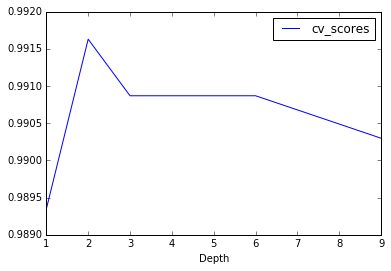

In [42]:
Depth = range(1,10)
score = []
for i in Depth:
      TreeClass = DecisionTreeClassifier(
                max_depth = i,
                min_samples_leaf = 5)
      scores = cross_val_score(TreeClass, X_test, y_test, cv=10)
      score.append(np.mean(scores))

Depth_Choice_df = pd.DataFrame({'cv_scores': score ,'Depth': Depth})
Depth_Choice_df.plot(x ='Depth',y = 'cv_scores' )

#It seems like at depth = 4 we achieved the best result

In [32]:
Depth_Choice_df.head()

,Depth,cv_scores
0,1,0.989347
1,2,0.991629
2,3,0.990869
3,4,0.990869
4,5,0.990869


In [34]:
TreeClass = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)
TreeClass.fit(X_train,y_train)
ImportanceDataFrame = pd.DataFrame({'feature':X.columns.values, 'importance':TreeClass.feature_importances_})
ImportanceDataFrame.sort_values(by = ['importance'],ascending = 0)

,feature,importance
7,is_limited,0.665275
6,is_bullet,0.328164
14,d_saturday,0.006561
66,tid_263.0,0.000000
77,tid_282.0,0.000000
76,tid_279.0,0.000000
75,tid_278.0,0.000000
74,tid_277.0,0.000000
73,tid_274.0,0.000000
72,tid_273.0,0.000000


In [48]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#example-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Yes','No'], rotation=45)
    plt.yticks(tick_marks, ['Yes','No'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix:
[[20658    36]
 [  129   198]]
Normalized
[[ 0.998  0.002]
 [ 0.394  0.606]]


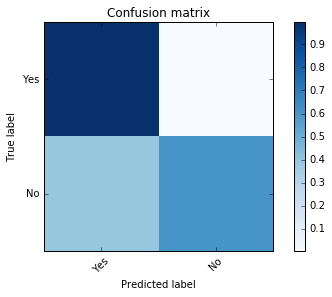

In [53]:
from sklearn.metrics import confusion_matrix
y_hat = TreeClass.predict(X)
cmat = confusion_matrix(y, y_hat)
c_norm = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]
print "Confusion matrix:"
print cmat
print "Normalized"
print np.round(c_norm,3)
plot_confusion_matrix(c_norm) # Normalized

[ 0.00219298  0.00219298  0.00219298 ...,  0.00219298  0.00219298
  0.00219298]
0.931494495738


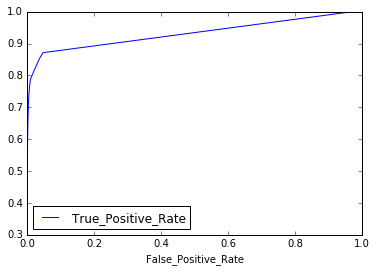

In [56]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
TreeClass.fit(X,y)
y_hat_probability = TreeClass.predict_proba(X).T[1] 
print(y_hat_probability)
print(roc_auc_score(y, y_hat_probability))
vals = roc_curve(y, y_hat_probability)  
Roc_DataFrame = pd.DataFrame({'False_Positive_Rate':vals[0],'True_Positive_Rate':vals[1]})
Roc_DataFrame.plot(x = 'False_Positive_Rate' , y = 'True_Positive_Rate' ) 

### As a check, consider Feature selection

In [57]:
from sklearn import feature_selection
pvals = feature_selection.f_regression(X,y)[1] 
sorted(zip(X.columns.values,np.round(pvals,4)),key=lambda x:x[1],reverse=True)

[('tid_139.0', 0.82789999999999997),
 ('tid_221.0', 0.82789999999999997),
 ('tid_231.0', 0.82789999999999997),
 ('tid_257.0', 0.82789999999999997),
 ('tid_274.0', 0.82789999999999997),
 ('tid_370.0', 0.82789999999999997),
 ('tid_376.0', 0.82789999999999997),
 ('tid_147.0', 0.75109999999999999),
 ('tid_159.0', 0.75109999999999999),
 ('tid_197.0', 0.75109999999999999),
 ('tid_217.0', 0.75109999999999999),
 ('tid_220.0', 0.75109999999999999),
 ('tid_227.0', 0.75109999999999999),
 ('tid_264.0', 0.75109999999999999),
 ('tid_279.0', 0.75109999999999999),
 ('tid_284.0', 0.75109999999999999),
 ('tid_287.0', 0.75109999999999999),
 ('tid_366.0', 0.75109999999999999),
 ('tid_380.0', 0.75109999999999999),
 ('tid_385.0', 0.75109999999999999),
 ('tid_386.0', 0.75109999999999999),
 ('tid_138.0', 0.4521),
 ('tid_258.0', 0.4521),
 ('tid_267.0', 0.4521),
 ('tid_277.0', 0.4521),
 ('tid_278.0', 0.4521),
 ('tid_283.0', 0.4521),
 ('tid_323.0', 0.4521),
 ('tid_134.0', 0.39429999999999998),
 ('tid_193.0', 0.3

In [ ]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X,y)
X_lr=df[['windspeed','t_northbound','precipiation','d_friday']]
# localize your search around the maximum value you found
c_list = np.logspace(-1,1,21) 
c_index = np.linspace(-1,1,21)
#C is just the inverse of Lambda - the smaller the C - the stronger the
#regulatization. The smaller C's choose less variables
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score, penalty = "l1")
    cv_scores.append(cross_val_score(lm,X,y,cv=10).mean())


C_Choice_df = pd.DataFrame({'cv_scores': cv_scores ,'Log_C': c_index })
C_Choice_df.plot(x ='Log_C',y = 'cv_scores' )
# it sounds like our best choice is C = -0.1  (we chose the most restrictive option)